<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 02 - Classification and Clustering

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’. 

### Importing Packages

In [10]:
import pandas as pd
import os
import random
import numpy as np
import pickle 
import re,string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec,LdaMulticore, TfidfModel, CoherenceModel
from gensim import corpora
from gensim import similarities
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.models import LsiModel,LdaModel

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
import warnings
warnings.filterwarnings('ignore')

### Mount Google Drive to Colab Environment

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

### Functions Create TFIDF and Doc2vec Matrices

In [3]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc


In [4]:
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

### Latent Semantic Analysis, Allocation, Word2Vec Matrix 
1. Latent Semantic Analysis Example
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

### Latent Semantic Analysis Using Gensim's Implementation

In [5]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

### Latent Semantic Analysis Example

In [6]:
def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)

    LSA.fit(tfidf_matrix)


    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

### Latent Dirichlet Allocation

In [7]:
def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

### Word2Vec Matrix Generation

In [8]:
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df


#### Section of Code Prepares the Required Variables for Functions 

In [9]:
#read in class corpus csv into python
data=pd.read_csv(r'/content/gdrive/MyDrive/input/Class_Corpus_v2.csv')

#data= data[data["Movie Title"]=="Frozen_2"]
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()


NameError: ignored

In [105]:
data.shape

(10, 9)

In [106]:
# text_list=df_sampled['Text'].tolist()
# print(text_list[1])
# tokenized_reviews = lemmatization(text_list)
# print(tokenized_reviews[1])

In [107]:
dictionary = corpora.Dictionary(processed_text)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in processed_text]

In [110]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=1, random_state=100,
                chunksize=1000, passes=50,iterations=100)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [111]:
lda_model.print_topics()

[(0,
  '0.014*"frozen" + 0.006*"disney" + 0.005*"movie" + 0.005*"first" + 0.004*"arendelle" + 0.004*"kristen" + 0.004*"elsas" + 0.003*"kristoff" + 0.003*"forest" + 0.003*"animation"')]

In [ ]:
pip install pyldavis

In [43]:
import pyLDAvis
#import pyLDAvis.gensim
#import pyLDAvis.sklearn
import pyLDAvis.gensim_models


In [64]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.025476  0.039810       1        1  49.294355
3      0.174371 -0.040635       2        1  25.641234
5     -0.002601  0.129927       3        1  10.458071
6     -0.080093 -0.102415       4        1   7.807564
7     -0.007417 -0.018142       5        1   6.655177
0     -0.011757 -0.001709       6        1   0.028720
1     -0.011757 -0.001709       7        1   0.028720
2     -0.011757 -0.001709       8        1   0.028720
4     -0.011757 -0.001709       9        1   0.028720
8     -0.011757 -0.001709      10        1   0.028720, topic_info=               Term       Freq      Total Category  logprob  loglift
74           frozen  60.000000  60.000000  Default  30.0000  30.0000
1277          queer   9.000000   9.000000  Default  29.0000  29.0000
72           forest  12.000000  12.000000  Default  28.0000  28.0000
214       animation  13.000000  13.000000  Default  27.0000  27.0000
53            elsas  14.000000  14.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
445   andersonlopez   0.000525   7.073858  Topic10  -7.5486  -1.3528
1082       computer   0.000525   3.797027  Topic10  -7.5486  -0.7306
33            could   0.000525   7.712845  Topic10  -7.5486  -1.4392
54        enchanted   0.000525   9.185680  Topic10  -7.5486  -1.6140
754           seems   0.000525   4.695759  Topic10  -7.5486  -0.9430

[641 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
423       1  0.389683  accompanying
423       3  0.389683  accompanying
208       1  0.307522        action
208       2  0.307522        action
208       4  0.307522        action
...     ...       ...           ...
420       4  0.128999         years
1897      3  0.989317        yelana
863       1  0.868483         young
863       3  0.217121         young
1161      2  0.849725         youre

[570 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 6, 7, 8, 1, 2, 3, 5, 9])

In [65]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_text, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -6.866691835426934

Coherence Score:  0.3235912365873397


# Method to find optimal number of topics Code from:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

In [66]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [67]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=processed_text, start=2, limit=50, step=1)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

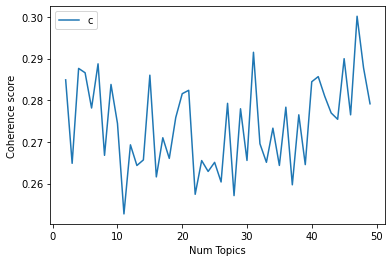

In [68]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [69]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2849
Num Topics = 3  has Coherence Value of 0.2648
Num Topics = 4  has Coherence Value of 0.2876
Num Topics = 5  has Coherence Value of 0.2866
Num Topics = 6  has Coherence Value of 0.2781
Num Topics = 7  has Coherence Value of 0.2887
Num Topics = 8  has Coherence Value of 0.2668
Num Topics = 9  has Coherence Value of 0.2838
Num Topics = 10  has Coherence Value of 0.2744
Num Topics = 11  has Coherence Value of 0.2527
Num Topics = 12  has Coherence Value of 0.2693
Num Topics = 13  has Coherence Value of 0.2643
Num Topics = 14  has Coherence Value of 0.2657
Num Topics = 15  has Coherence Value of 0.286
Num Topics = 16  has Coherence Value of 0.2616
Num Topics = 17  has Coherence Value of 0.271
Num Topics = 18  has Coherence Value of 0.266
Num Topics = 19  has Coherence Value of 0.2759
Num Topics = 20  has Coherence Value of 0.2816
Num Topics = 21  has Coherence Value of 0.2824
Num Topics = 22  has Coherence Value of 0.2574
Num Topics = 23  has Coh

In [89]:
model_list

In [90]:
# Select the model and print the topics
optimal_model = model_list[44]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(10,
  '0.005*"movie" + 0.005*"frozen" + 0.003*"first" + 0.003*"disney" + 0.002*"characters" + 0.002*"audiences" + 0.002*"forest" + 0.002*"queen" + 0.002*"better" + 0.002*"kristoff"'),
 (14,
  '0.021*"frozen" + 0.007*"first" + 0.007*"disney" + 0.006*"menzel" + 0.006*"doesnt" + 0.005*"could" + 0.005*"kristoff" + 0.005*"elsas" + 0.005*"sequel" + 0.004*"groff"'),
 (36,
  '0.015*"frozen" + 0.009*"disney" + 0.008*"first" + 0.006*"movie" + 0.006*"really" + 0.005*"queer" + 0.005*"elsas" + 0.004*"forest" + 0.004*"arendelle" + 0.004*"power"'),
 (43,
  '0.021*"frozen" + 0.007*"movie" + 0.006*"disney" + 0.006*"kristen" + 0.005*"arendelle" + 0.005*"elsas" + 0.005*"kristoff" + 0.004*"still" + 0.004*"jennifer" + 0.004*"chris"'),
 (24,
  '0.024*"frozen" + 0.008*"disney" + 0.007*"doesnt" + 0.006*"elsas" + 0.005*"menzel" + 0.005*"kristoff" + 0.005*"arendelle" + 0.005*"story" + 0.005*"kristen" + 0.004*"sequel"'),
 (25,
  '0.007*"still" + 0.007*"frozen" + 0.006*"elsas" + 0.006*"disney" + 0.004*"forest" 

In [85]:
optimal_model.show_topics()

[(43,
  '0.012*"frozen" + 0.007*"disney" + 0.004*"kristen" + 0.004*"feels" + 0.004*"kristoff" + 0.004*"arendelle" + 0.004*"world" + 0.004*"first" + 0.004*"sequel" + 0.004*"characters"'),
 (28,
  '0.013*"frozen" + 0.008*"movie" + 0.005*"disney" + 0.005*"arendelle" + 0.004*"original" + 0.004*"kristoff" + 0.004*"still" + 0.004*"queer" + 0.003*"forest" + 0.003*"thing"'),
 (16,
  '0.015*"frozen" + 0.006*"movie" + 0.006*"disney" + 0.006*"queer" + 0.006*"first" + 0.005*"voice" + 0.005*"arendelle" + 0.004*"kristen" + 0.004*"years" + 0.004*"people"'),
 (45,
  '0.012*"frozen" + 0.009*"movie" + 0.004*"disney" + 0.004*"elsas" + 0.004*"first" + 0.004*"arendelle" + 0.004*"still" + 0.003*"audiences" + 0.003*"forest" + 0.003*"kristoff"'),
 (37,
  '0.010*"frozen" + 0.009*"thing" + 0.008*"right" + 0.008*"kristen" + 0.007*"movie" + 0.007*"still" + 0.006*"jennifer" + 0.005*"story" + 0.005*"chris" + 0.005*"lopez"'),
 (10,
  '0.013*"frozen" + 0.006*"makes" + 0.006*"parents" + 0.006*"menzel" + 0.006*"feels" 

In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.003888 -0.011252       1        1  25.645369
1     -0.003641  0.002175       2        1  19.530866
6      0.002933 -0.009797       3        1  18.309538
8     -0.019858 -0.004869       4        1  18.240100
7      0.012070  0.003599       5        1   9.516175
3      0.002204 -0.004010       6        1   5.498743
2      0.009883  0.006995       7        1   3.195371
0     -0.011997  0.011963       8        1   0.031922
5      0.004519  0.005196       9        1   0.031917, topic_info=          Term       Freq      Total Category  logprob  loglift
74      frozen  53.000000  53.000000  Default  30.0000  30.0000
44      disney  20.000000  20.000000  Default  29.0000  29.0000
336      movie  18.000000  18.000000  Default  28.0000  28.0000
297      first  19.000000  19.000000  Default  27.0000  27.0000
8    arendelle  15.000000  15.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
206      world   0.001953   7.335509   Topic9  -6.3406  -0.1811
46      doesnt   0.002232  11.572464   Topic9  -6.2071  -0.5036
126     people   0.002082   9.099968   Topic9  -6.2770  -0.3330
89       idina   0.001938   7.777905   Topic9  -6.3483  -0.2474
110     menzel   0.002002  10.299416   Topic9  -6.3159  -0.4957

[665 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
210       1  0.349577    adults
210       4  0.349577    adults
1167      1  0.273593  allegory
1167      2  0.273593  allegory
1167      3  0.273593  allegory
...     ...       ...       ...
420       4  0.136126     years
863       1  0.255224     young
863       2  0.255224     young
863       3  0.255224     young
863       4  0.255224     young

[572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 7, 9, 8, 4, 3, 1, 6])

### Plot the LSA based on user defined number of topics and words

In [1]:
def plot_lsa(number_of_topics, words):

    ######################################
    #Function to plot the LSA based on user defined number of topics and words
    #EXPERIMENT WITH THESE PARAMETERS topics and words

    #####################################
    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model
    

### Plotting 6 topics and 10 words

In [2]:
model_6topic_10words = plot_lsa(6, 10)

NameError: ignored

### Plotting 2 topics and 10 words

[(0, '-0.513*"frozen" + -0.218*"movie" + -0.210*"disney" + -0.182*"first" + -0.135*"arendelle" + -0.126*"elsas" + -0.113*"kristen" + -0.109*"kristoff" + -0.107*"forest" + -0.106*"doesnt"'), (1, '0.329*"queer" + 0.165*"allegory" + 0.165*"mother" + -0.137*"audiences" + 0.132*"queerness" + 0.124*"voice" + 0.116*"forest" + 0.108*"coming" + 0.099*"inside" + 0.099*"watched"')]


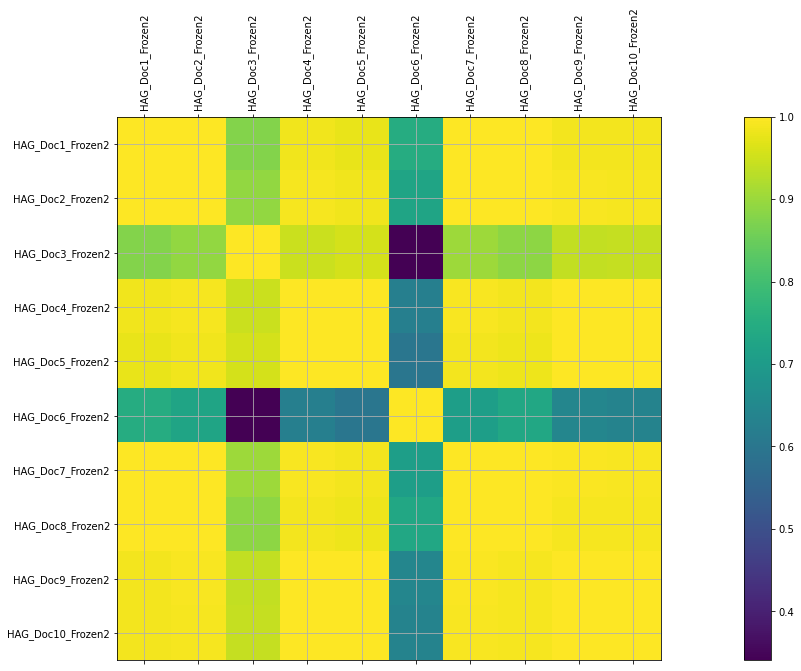

In [54]:
model_2topic_10words = plot_lsa(2, 10)

### Plotting 20 topics and 10 words

[(0, '-0.513*"frozen" + -0.218*"movie" + -0.210*"disney" + -0.182*"first" + -0.135*"arendelle" + -0.126*"elsas" + -0.113*"kristen" + -0.109*"kristoff" + -0.107*"forest" + -0.106*"doesnt"'), (1, '0.329*"queer" + 0.165*"allegory" + 0.165*"mother" + -0.137*"audiences" + 0.132*"queerness" + 0.124*"voice" + 0.116*"forest" + 0.108*"coming" + 0.099*"inside" + 0.099*"watched"'), (2, '0.235*"movie" + -0.172*"frozen" + 0.134*"queer" + 0.119*"audiences" + -0.114*"kingdom" + 0.110*"would" + -0.094*"kristen" + -0.088*"water" + 0.084*"characters" + 0.083*"words"'), (3, '0.210*"frozen" + -0.132*"still" + -0.129*"arendelle" + 0.118*"sequel" + -0.106*"animation" + -0.092*"northuldra" + -0.083*"predecessor" + -0.082*"sequence" + 0.082*"doesnt" + -0.081*"media"'), (4, '0.149*"animation" + -0.139*"elsas" + 0.119*"years" + 0.116*"arendelle" + -0.097*"disney" + 0.090*"takes" + 0.088*"computer" + -0.087*"around" + 0.087*"action" + -0.084*"power"'), (5, '0.172*"frozen" + -0.150*"disney" + 0.135*"still" + -0.1

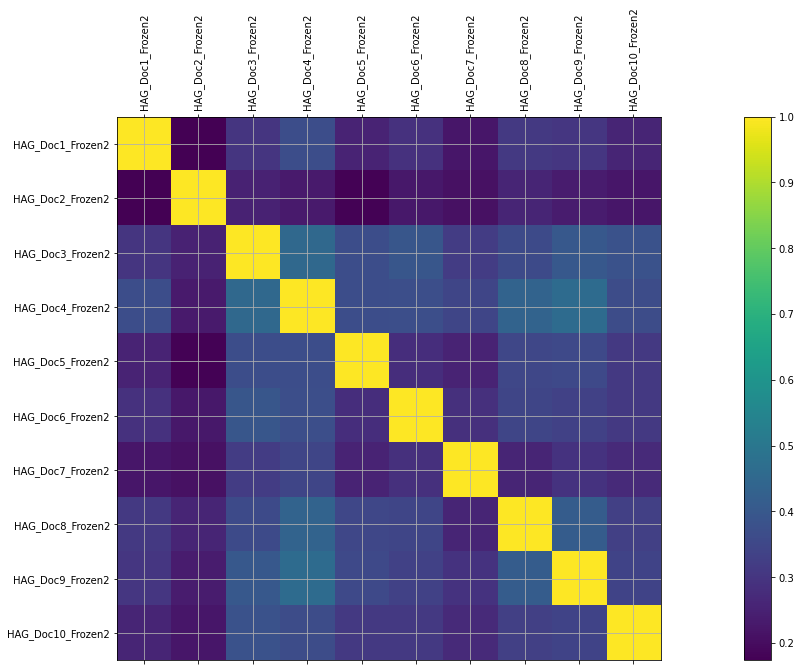

In [55]:
model_20topic_10words =plot_lsa(20, 10)

### Compare LSA Model Coherence

In [56]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '-0.513*"frozen" + -0.218*"movie" + -0.210*"disney" + -0.182*"first" + -0.135*"arendelle" + -0.126*"elsas" + -0.113*"kristen" + -0.109*"kristoff" + -0.107*"forest" + -0.106*"doesnt"'), (1, '0.329*"queer" + 0.165*"allegory" + 0.165*"mother" + -0.137*"audiences" + 0.132*"queerness" + 0.124*"voice" + 0.116*"forest" + 0.108*"coming" + 0.099*"inside" + 0.099*"watched"'), (2, '0.235*"movie" + -0.172*"frozen" + 0.134*"queer" + 0.119*"audiences" + -0.114*"kingdom" + 0.110*"would" + -0.094*"kristen" + -0.088*"water" + 0.084*"characters" + 0.083*"words"'), (3, '0.210*"frozen" + -0.132*"still" + -0.129*"arendelle" + 0.118*"sequel" + -0.106*"animation" + -0.092*"northuldra" + -0.083*"predecessor" + -0.082*"sequence" + 0.082*"doesnt" + -0.081*"media"'), (4, '-0.149*"animation" + 0.139*"elsas" + -0.119*"years" + -0.116*"arendelle" + 0.097*"disney" + -0.090*"takes" + -0.088*"computer" + 0.087*"around" + -0.087*"action" + 0.084*"power"'), (5, '0.172*"frozen" + -0.150*"disney" + 0.135*"still" + -0

### Latent Dirichlet Allocation Using Gensim's implementation

In [57]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

### Execute create_gensim_lda_model Function

[(0, '0.011*"frozen" + 0.006*"disney" + 0.006*"movie" + 0.006*"arendelle" + 0.006*"first" + 0.004*"animation" + 0.004*"kristen" + 0.004*"forest" + 0.003*"doesnt" + 0.003*"kristoff"'), (1, '0.012*"frozen" + 0.007*"movie" + 0.007*"disney" + 0.006*"first" + 0.005*"arendelle" + 0.004*"elsas" + 0.004*"kristen" + 0.004*"forest" + 0.003*"still" + 0.003*"kristoff"'), (2, '0.014*"frozen" + 0.006*"disney" + 0.006*"first" + 0.005*"movie" + 0.004*"sequel" + 0.004*"original" + 0.004*"kristen" + 0.004*"arendelle" + 0.004*"elsas" + 0.003*"story"'), (3, '0.019*"frozen" + 0.006*"disney" + 0.005*"first" + 0.004*"movie" + 0.004*"doesnt" + 0.004*"menzel" + 0.004*"arendelle" + 0.004*"kristoff" + 0.004*"elsas" + 0.004*"forest"'), (4, '0.012*"frozen" + 0.004*"movie" + 0.004*"disney" + 0.004*"arendelle" + 0.003*"kristoff" + 0.003*"elsas" + 0.003*"first" + 0.003*"kristen" + 0.003*"sequel" + 0.003*"animation"'), (5, '0.015*"frozen" + 0.005*"disney" + 0.004*"first" + 0.004*"movie" + 0.004*"animation" + 0.004*"kr

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

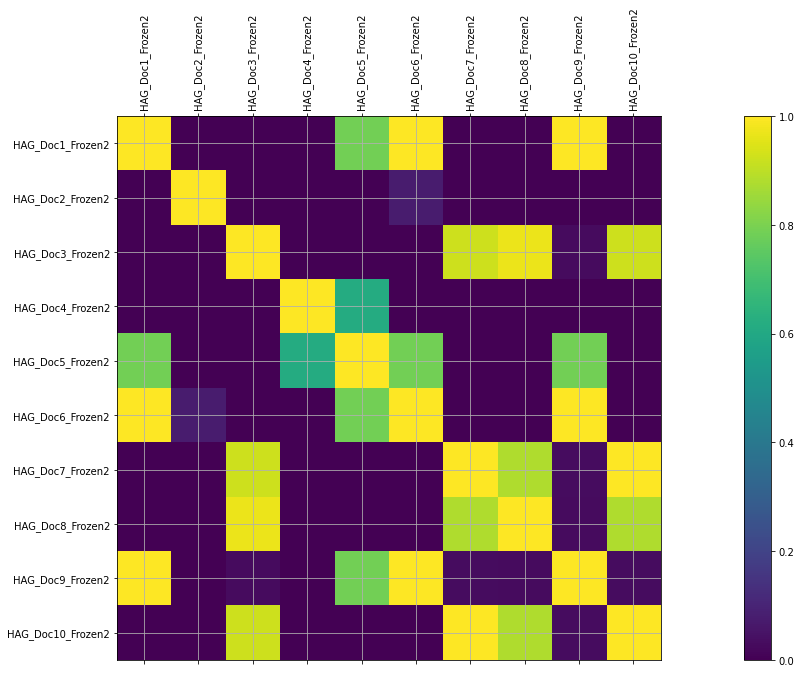

In [58]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=6
words=10
#####################################
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LSA Model Coherence

In [59]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}   

print(coherence)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0, '0.016*"frozen" + 0.007*"movie" + 0.006*"first" + 0.006*"disney" + 0.005*"elsas" + 0.004*"doesnt" + 0.004*"kristoff" + 0.004*"original" + 0.004*"arendelle" + 0.003*"forest"'), (1, '0.013*"frozen" + 0.008*"disney" + 0.005*"first" + 0.004*"arendelle" + 0.004*"kristen" + 0.004*"forest" + 0.004*"movie" + 0.004*"elsas" + 0.003*"animation" + 0.003*"story"'), (2, '0.009*"frozen" + 0.005*"first" + 0.005*"movie" + 0.004*"disney" + 0.004*"kristen" + 0.003*"still" + 0.003*"thing" + 0.003*"arendelle" + 0.003*"animation" + 0.003*"right"'), (3, '0.019*"frozen" + 0.008*"disney" + 0.006*"movie" + 0.005*"first" + 0.004*"arendelle" + 0.004*"queer" + 0.004*"forest" + 0.004*"kristen" + 0.004*"elsas" + 0.003*"sequel"'), (4, '0.008*"frozen" + 0.005*"movie" + 0.004*"disney" + 0.003*"first" + 0.003*"doesnt" + 0.003*"forest" + 0.003*"kristen" + 0.003*"kristoff" + 0.003*"elsas" + 0.002*"groff"'), (5, '0.015*"frozen" + 0.007*"arendelle" + 0.006*"disney" + 0.005*"first" + 0.005*"kristen" + 0.004*"movie" + 0.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0, '0.009*"frozen" + 0.006*"disney" + 0.006*"arendelle" + 0.004*"movie" + 0.004*"first" + 0.004*"still" + 0.004*"kristen" + 0.003*"elsas" + 0.003*"kristoff" + 0.003*"story"'), (1, '0.017*"frozen" + 0.006*"disney" + 0.006*"movie" + 0.006*"first" + 0.004*"animation" + 0.004*"forest" + 0.004*"kristen" + 0.004*"elsas" + 0.004*"doesnt" + 0.004*"sequel"')]


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0, '0.018*"frozen" + 0.007*"disney" + 0.006*"first" + 0.005*"kristen" + 0.005*"arendelle" + 0.005*"movie" + 0.004*"doesnt" + 0.004*"animation" + 0.004*"sequel" + 0.004*"menzel"'), (1, '0.007*"frozen" + 0.004*"movie" + 0.003*"first" + 0.003*"disney" + 0.002*"kristoff" + 0.002*"arendelle" + 0.002*"elsas" + 0.002*"queen" + 0.002*"world" + 0.002*"menzel"'), (2, '0.012*"frozen" + 0.006*"disney" + 0.005*"movie" + 0.004*"kristen" + 0.004*"first" + 0.004*"arendelle" + 0.004*"still" + 0.004*"elsas" + 0.004*"groff" + 0.003*"original"'), (3, '0.013*"frozen" + 0.006*"disney" + 0.004*"first" + 0.004*"arendelle" + 0.004*"still" + 0.004*"movie" + 0.004*"kristen" + 0.004*"kristoff" + 0.004*"doesnt" + 0.003*"queen"'), (4, '0.019*"frozen" + 0.008*"first" + 0.007*"disney" + 0.006*"movie" + 0.005*"kristoff" + 0.005*"arendelle" + 0.004*"kristen" + 0.004*"still" + 0.004*"forest" + 0.004*"elsas"'), (5, '0.013*"frozen" + 0.006*"movie" + 0.006*"disney" + 0.004*"arendelle" + 0.004*"first" + 0.004*"kristen" + 

### Demonstrate the following supervised/unsupervised learning methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### Functions Process Text and Create the Required TFIDF and Doc2vec Matrices

In [60]:
#functions used to 
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range= ngram_range)

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix


def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

